Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jupyter_black

jupyter_black.load()

c:\Users\Hannah Blaurock\AppData\Local\Programs\Python\Python39\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.4.0
aiofiles                     0.6.0
aiohttp                      3.8.5
aiosignal                    1.3.1
anyio                        3.6.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asgiref                      3.6.0
aspose-words                 23.4.0
asttokens                    2.2.1
astunparse                   1.6.3
async-timeout                4.0.3
atomicwrites                 1.4.1
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
black                        23.3.0
bleach                       6.0.0
build                        1.2.1
CacheControl                 0.14.0
cachetools                   5.3.0
captum                       0.6.0
catboost                     1.2
certifi                      2022.12.7
cffi                         1.15.1
cfgv                         

## Context
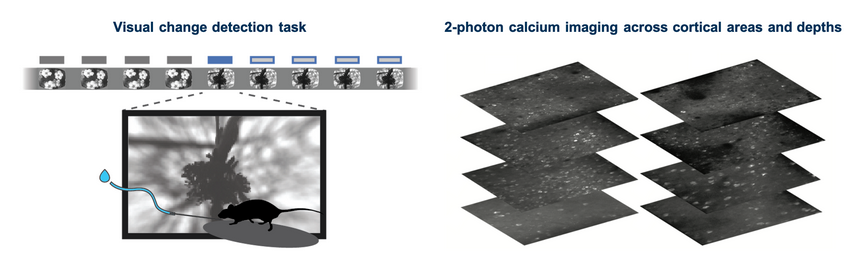

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

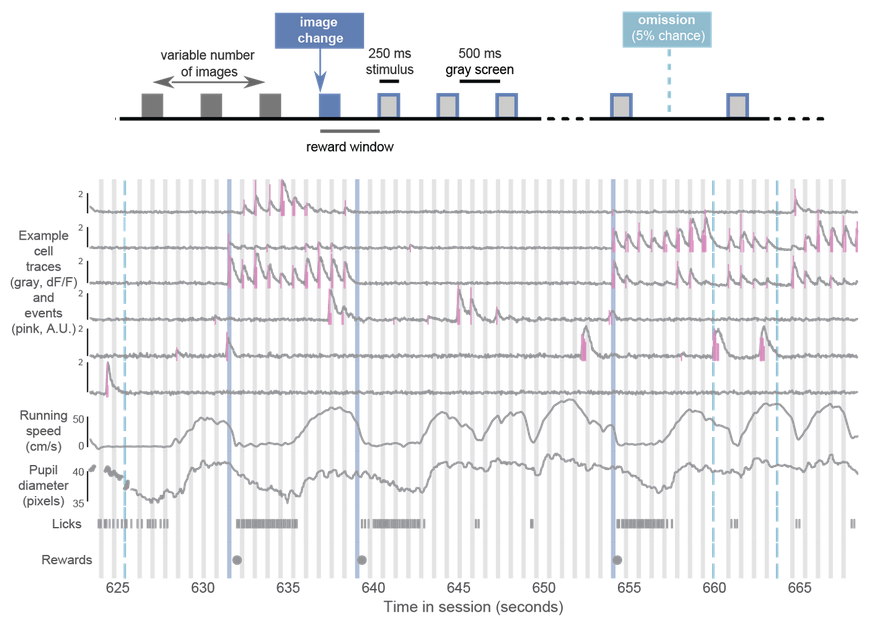

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [3]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



# 1. Data Exploration

In [5]:
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]
experiment_start = stim_epoch_table["start"][0]
print("Experiment start:", experiment_start)

Experiment start: drifting_gratings


In [6]:
stim_table

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,225.0,0.0,747.0,807.0
1,2.0,180.0,0.0,837.0,897.0
2,4.0,90.0,0.0,927.0,987.0
3,1.0,270.0,0.0,1018.0,1077.0
4,4.0,135.0,0.0,1108.0,1168.0
...,...,...,...,...,...
623,4.0,315.0,0.0,114794.0,114854.0
624,2.0,45.0,0.0,114884.0,114944.0
625,4.0,180.0,0.0,114975.0,115034.0
626,4.0,270.0,0.0,115065.0,115125.0


In [14]:
# TODO insert exploration code and plots here!

In [8]:
# we checked the data and found that the difference between the time points is not constant and varies by a small amount # TODO justify!
fs = 1 / np.mean(np.diff(t))  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Sampling frequency is 30.070762151865303 Hz, Time Interval is 0.03325489373863341 s


# 2. Preprocessing

TODO add text here!

## 2.1 Filtering

TODO add text here!

In [12]:
# butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (fs / 2)

# create abs(dff)
# dff_abs[dff_abs < 0] = 0  # = np.abs(dff)

dff_butter = utils.butter_filter_signal(
    x=dff, low=low, high=high, fs=fs, order=4
)  # TODO play with parameters, ich weiß nicht mehr was die bedeuten

# as butterworth filter introduces negative values, we need to set them to zero
dff_butter[dff_butter < 0] = 0

# wiener filter
window_wiener = 15  # TODO sollten wir hier eine windows size nehmen, die einer spike dauer entspricht?
dff_wiener = utils.wiener_filter_signal(x=dff, window=window_wiener)

# both filters applied sequentially
dff_both = utils.wiener_filter_signal(x=dff_butter, window=window_wiener)

c:\Users\Hannah Blaurock\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Hannah Blaurock\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


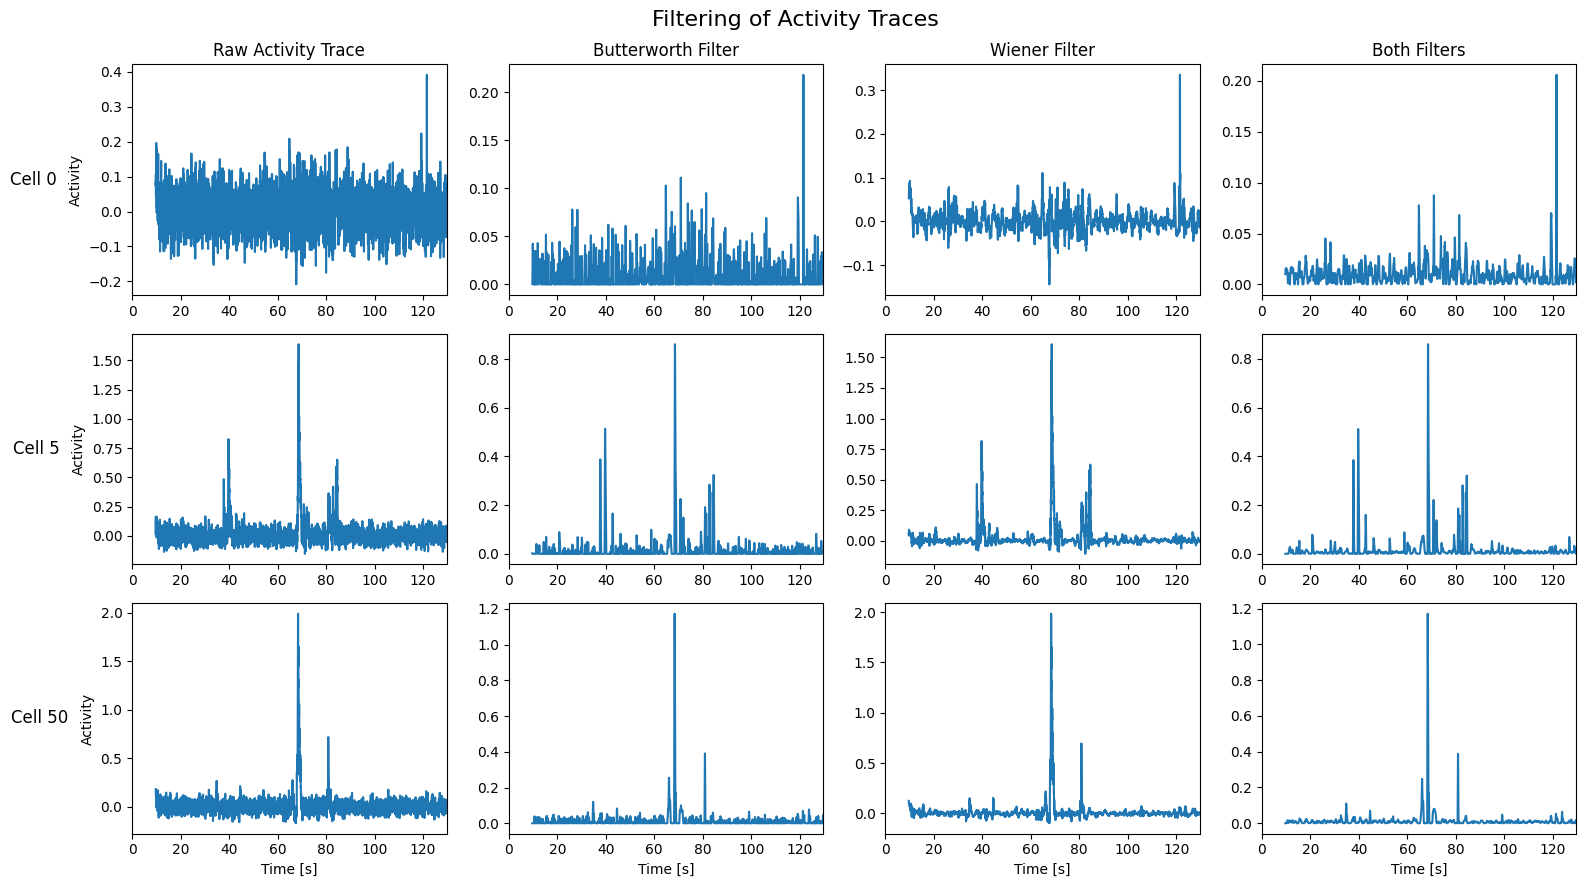

In [13]:
# plot the results for some cells
cell_idxs = [0, 5, 50]
# start and end index for time frame to show
tMin = 0
tMax = int(120 / dt)  # len(t)

column_title = [
    "Raw Activity Trace",
    "Butterworth Filter",
    "Wiener Filter",
    "Both Filters",
]
row_title = [f"Cell {i}" for i in cell_idxs]

fig, axs = plt.subplots(
    len(cell_idxs), 4, figsize=(16, len(cell_idxs) * 3), tight_layout=True
)
for i, cIdx in enumerate(cell_idxs):
    axs[i, 0].plot(t[tMin:tMax], dff[cIdx][tMin:tMax])  # raw data
    axs[i, 1].plot(t[tMin:tMax], dff_butter[cIdx][tMin:tMax])  # butterworth
    axs[i, 2].plot(t[tMin:tMax], dff_wiener[cIdx][tMin:tMax])  # wiener
    axs[i, 3].plot(t[tMin:tMax], dff_both[cIdx][tMin:tMax])  # both

    axs[i, 0].set_ylabel("Activity")

for col in range(4):
    axs[0, col].set_title(column_title[col])
    axs[len(cell_idxs) - 1, col].set_xlabel("Time [s]")

for ax, row in zip(axs[:, 0], row_title):
    ax.annotate(
        row,
        (0, 0.5),
        xytext=(-ax.yaxis.labelpad - 5, 0),
        xycoords=ax.yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
        size="large",
    )

for ax in axs.flatten():
    ax.set_xlim(-dt, t[tMax] + dt)

fig.suptitle("Filtering of Activity Traces", fontsize=16)
fig.subplots_adjust(left=0.15, right=0.9, top=0.95)
plt.show()

Todo: Conclusion?

## 2.3 Deconvolution

TODO Text

- Thresholding wird auch von https://doi.org/10.1371/journal.pcbi.1005423 durchgeführt, liefert ganz gut Ergebnisse

In [16]:
# deconvolution using oopsi
thresh = 0.05  # TODO adaptive thresholding?

# this runs for a while. You can load the results from file in the cell below instead.
# If you want to run it, set from_file=False
from_file = True
deconv_oopsi = {}
if not from_file:
    # deconv_oopsi = utils.oopsi_inference(
    #     dff=dff_wiener, dt=dt, thresh=thresh, to_file=True
    # )
    deconv_oasis = utils.oasis_inference(dff=dff, dt=dt, thresh=thresh, to_file=True)
else:
    deconv_oopsi = utils.load_inferred_spikes("../data/inference_oopsi.pkl")
    deconv_oasis = utils.load_inferred_spikes("../data/inference_oasis.pkl")

for k in deconv_oopsi.keys():
    print(f"Key: {k}, Shape: {deconv_oopsi[k].shape}")

Key: spikes, Shape: (189, 105968)
Key: deconv, Shape: (189, 105968)
Key: infspikes, Shape: (189, 105968)


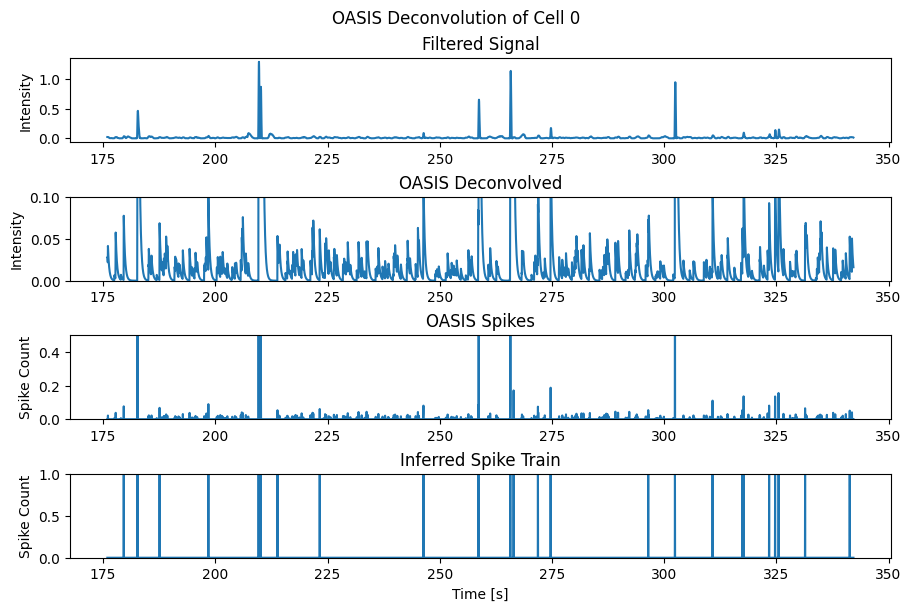

In [17]:
# plot the results for a cell
start = 5000
end = 10000
cell_idx = 0

fig, axs = plt.subplots(4, 1, figsize=(9, 6), layout="constrained")
axs[0].plot(t[start:end], dff_both[cell_idx][start:end])
axs[0].set_title("Filtered Signal")
axs[0].set_ylabel("Intensity")

axs[1].plot(t[start:end], deconv_oasis["deconv"][cell_idx, start:end])
axs[1].set_title("OASIS Deconvolved")
axs[1].set_ylim(0, 0.1)
axs[1].set_ylabel("Intensity")

axs[2].plot(t[start:end], deconv_oasis["spikes"][cell_idx, start:end])
axs[2].set_title("OASIS Spikes")
axs[2].set_ylim(0, 0.5)
axs[2].set_ylabel("Spike Count")

axs[3].plot(t[start:end], deconv_oasis["infspikes"][cell_idx, start:end])
axs[3].set_title("Inferred Spike Train")
axs[3].set_ylim(0, 1)
axs[3].set_ylabel("Spike Count")


plt.xlabel("Time [s]")
plt.suptitle(f"OASIS Deconvolution of Cell {cell_idx}")

plt.show()

## 2.4 Intermediate Analysis

TODO Text!

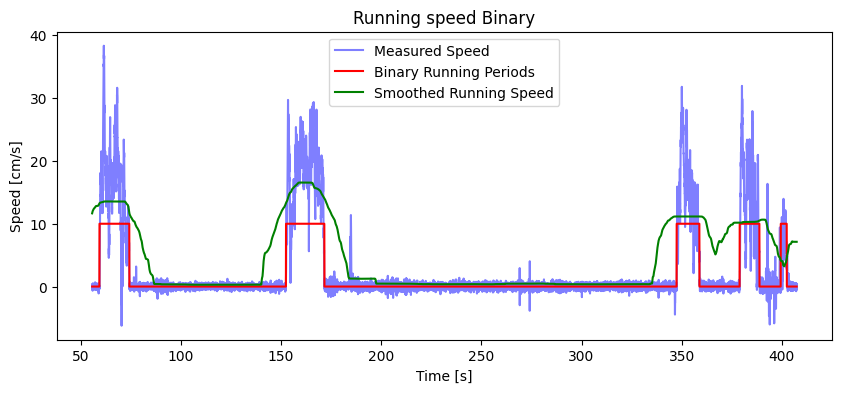

In [11]:
# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)

# convolution und smoothing mit root mean squared error
# Window size: we apply quite heavy smoothing for better visualization --> between 500-1000 is feasible here
running_smooth = utils.window_rms(running_speed, 750)

start = 1400
end = 12000

fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.plot(
    t[start:end],
    running_speed[start:end],
    color="blue",
    label="Measured Speed",
    alpha=0.5,
)
axs.plot(
    t[start:end],
    running_periods[start:end] * 10,
    color="red",
    label="Binary Running Periods",
)
axs.plot(
    t[start:end],
    running_smooth[start:end],
    color="green",
    label="Smoothed Running Speed",
)
axs.set_title("Running speed Binary")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Speed [cm/s]")
plt.legend()
plt.show()

In [28]:
start = int(1 / dt) * 1500
end = int(1 / dt) * 3000
t[start:end]

array([1506, 1506, 1506, ..., 3002, 3002, 3002])

TypeError: slice indices must be integers or None or have an __index__ method

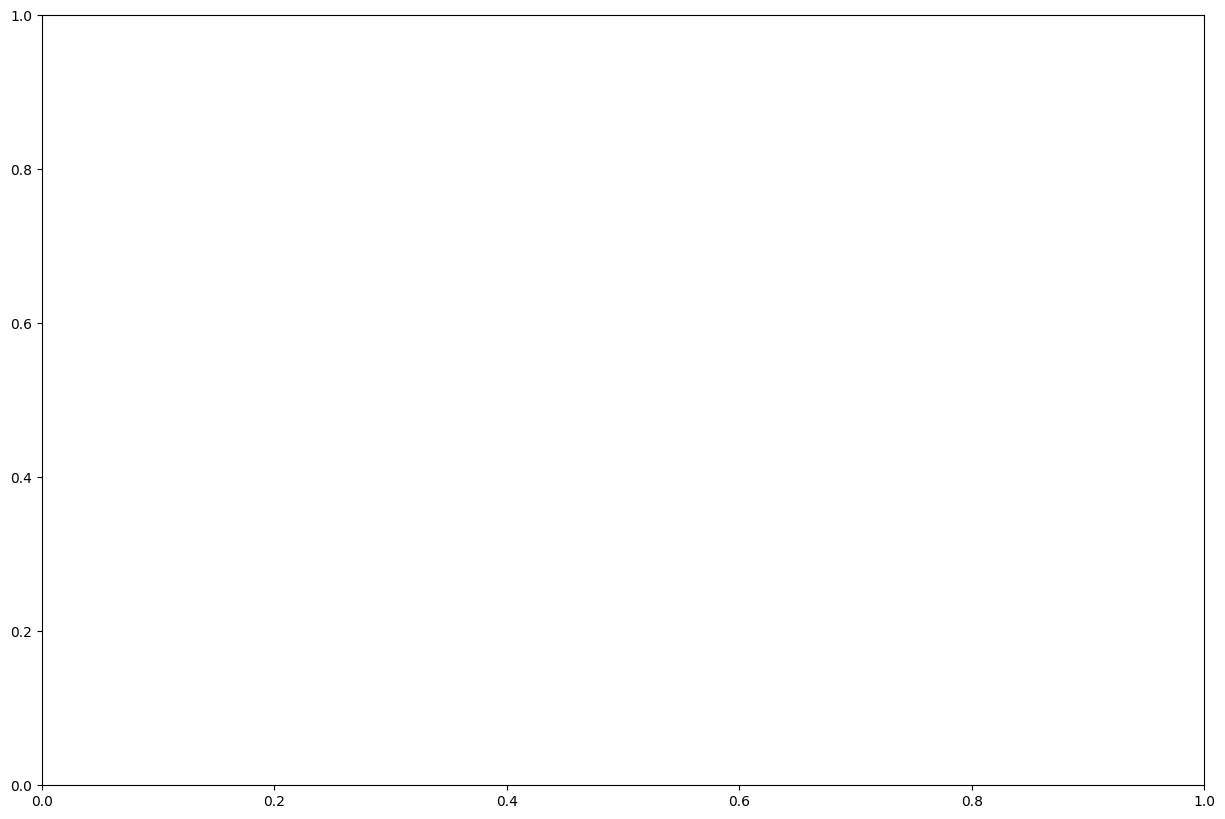

In [25]:
# plot the detected spikes per cell and running speed
# Window
start = int(1 / dt) * 1500
end = int(1 / dt) * 3000
# all Data
start = experiment_start
end = len(t) - 1

show_epochs = False
show_running = True

fig, axs = plt.subplots(figsize=(15, 10))
for cellIdx in range(dff.shape[0]):
    spike_train_cell = deconv_oasis["infspikes"][cellIdx, :]
    # create binary array for spikes and no spikes in spike train
    spike_binary = np.ones_like(spike_train_cell) * -50
    spike_binary[spike_train_cell == 1] = cellIdx
    axs.plot(
        t[start:end],
        spike_binary[start:end],
        marker="|",
        linestyle="None",
        color="k",
        markersize=2,
    )

# mark the epochs where the locally sparse noise stimulus is not shown
# other_stimuli = utils.get_epochs_in_range(stim_epoch_table, start, end)
# if show_epochs and not other_stimuli.empty:
#     for i in range(other_stimuli.shape[0]):
#         ep_start = other_stimuli.iloc[i]["start"]
#         ep_end = other_stimuli.iloc[i]["end"]
#         if i == 0:
#             axs.axvspan(
#                 t[ep_start], t[ep_end], color="gray", alpha=0.2, label="Other Stimulus"
#             )
#         else:
#             axs.axvspan(t[ep_start], t[ep_end], color="gray", alpha=0.2)

# # mark the running periods with a red line
# running_epochs = utils.get_epochs_in_range(
#     utils.get_running_periods_table(running_periods), start, end
# )
# running_epochs = running_epochs[running_epochs["stimulus"] == "running"]
# if show_running and not running_epochs.empty:
#     for i in range(running_epochs.shape[0]):
#         r_start = running_epochs.iloc[i]["start"]
#         r_end = running_epochs.iloc[i]["end"]
#         if i == 0:
#             axs.axvspan(
#                 t[r_start], t[r_end], color="blue", alpha=0.3, label="Running Period"
#             )
#         else:
#             axs.axvspan(t[r_start], t[r_end], color="blue", alpha=0.3)

axs.plot(
    t[start:end],
    running_smooth[start:end] + dff.shape[0] + 1,
    color="red",
    label="Smoothed Running Speed",
)

# TODO: yticks ab dff.shape[0] und legende (rot = running speed) hin
axs.set_xlim(t[start] - 50, t[end] + 50)
axs.set_ylim(-1, dff.shape[0] + 30)
axs.set_xlabel("Time [s]")
axs.set_ylabel("Cell")
# if not running_epochs.empty or not other_stimuli.empty:
#     plt.legend()
plt.legend()
plt.show()

In [13]:
# TODO running periods correlieren lassen
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr
import statsmodels.stats.multitest as smm


# Function to analyze spike and running period correlation
def analyze_spike_running_correlation(spiketrains, running_period):
    n_cells, n_measurements = spiketrains.shape

    # Ensure running_period is boolean
    running_period = running_period.astype(bool)

    # Initialize lists to store results
    p_values = []

    # Iterate over each cell to perform the statistical test
    for cell in range(n_cells):
        # Get spikes for running and non-running periods
        spikes_running = spiketrains[cell, running_period]
        spikes_non_running = spiketrains[cell, ~running_period]

        # Calculate the average spike rate during running and non-running periods
        rate_running = np.mean(spikes_running)
        rate_non_running = np.mean(spikes_non_running)

        # Perform unpaired statistical test
        if np.var(spikes_running) == 0 or np.var(spikes_non_running) == 0:
            # If there's no variation, set p-value to 1.0
            p_value = 1.0
        else:
            # Use independent t-test or Mann-Whitney U test
            t_stat, p_value = ttest_ind(
                spikes_running, spikes_non_running, equal_var=False
            )

        p_values.append(p_value)

    # Apply multiple comparisons correction (Bonferroni)
    corrected_p_values = smm.multipletests(p_values, method="bonferroni")[1]

    # Identify significant cells
    significant_cells = np.where(corrected_p_values < 0.05)[0]

    return significant_cells, corrected_p_values


assert running_periods.shape[0] == deconv_oopsi["infspikes"].shape[1]
analyze_spike_running_correlation(deconv_oopsi["infspikes"], running_periods)

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  15,
         16,  17,  19,  20,  21,  22,  23,  24,  25,  27,  28,  30,  33,
         34,  35,  36,  37,  38,  41,  42,  43,  47,  49,  50,  52,  53,
         54,  55,  56,  57,  58,  60,  62,  64,  65,  67,  70,  71,  73,
         74,  76,  77,  80,  81,  83,  84,  86,  87,  88,  89,  90,  92,
         94,  95,  96,  98,  99, 100, 101, 102, 103, 105, 106, 107, 110,
        111, 112, 113, 114, 115, 116, 117, 119, 120, 130, 131, 132, 134,
        135, 136, 137, 138, 139, 141, 142, 145, 149, 150, 151, 153, 155,
        157, 158, 159, 161, 163, 164, 165, 166, 168, 169, 171, 172, 174,
        175, 178, 179, 180, 182, 183, 184, 187, 188], dtype=int64),
 array([1.00000000e+000, 1.00000000e+000, 4.11961260e-012, 4.59994351e-002,
        2.20496077e-002, 3.02984000e-033, 2.11249010e-028, 3.90191460e-035,
        1.84568461e-014, 1.66342559e-002, 2.68190332e-011, 6.78815159e-008,
        8.47300660e-003, 7.63007601e-001, 2.627

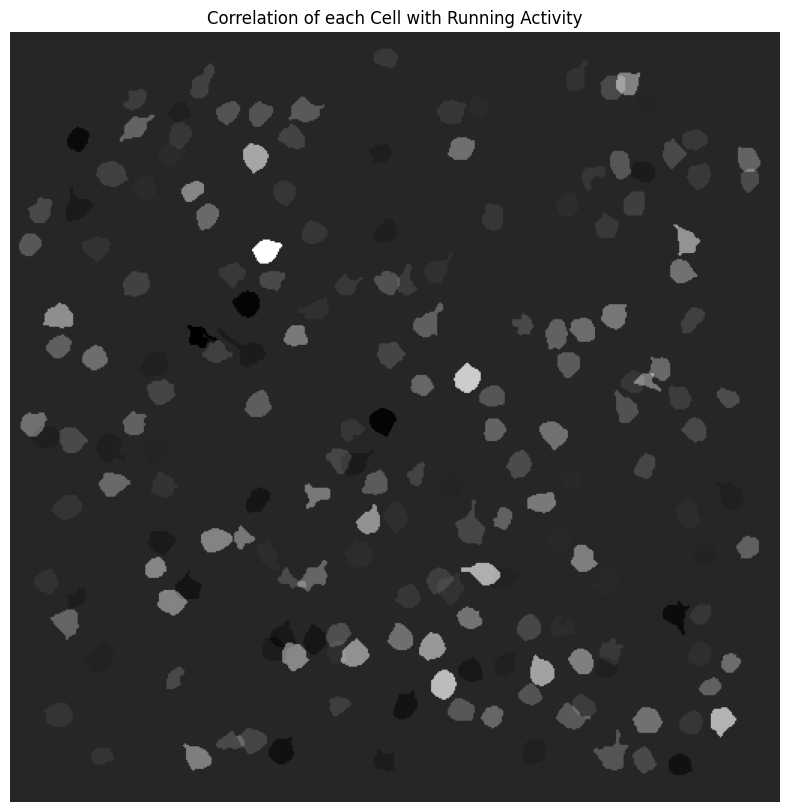

In [14]:
roi_masks = data["roi_masks"].copy()
roi_masks_corr = np.zeros_like(roi_masks, dtype=np.float64)
for cell in range(roi_masks.shape[0]):
    corr, p = pearsonr(deconv_oopsi["infspikes"][cell], running_speed)
    roi_masks_corr[cell, :, :] = np.where(
        roi_masks[cell, :, :].astype(np.float64) < 1, roi_masks[cell, :, :], corr
    )

roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

roi_masks_corr_sum = np.sum(roi_masks_corr, axis=0)
roi_masks_corr_sum = roi_masks_corr_sum / np.max(roi_masks_corr_sum)


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.imshow(roi_masks_sum, cmap="gray", alpha=0.5)
axs.imshow(
    roi_masks_corr_sum, cmap="gray"
)  # TODO diverging color bar mit limits einfügen... Stephan macht das noch

axs.set_title("Correlation of each Cell with Running Activity")
axs.axis("off")
plt.show()

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

In [41]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # Convert theta to radians
    theta_rad = np.deg2rad(θ)
    phi_rad = np.deg2rad(ϕ)

    f = np.exp(
        α
        + κ * (np.cos(2 * (theta_rad - phi_rad)) - 1)
        + ν * (np.cos(theta_rad - phi_rad) - 1)
    )
    return f

In [76]:
from scipy.optimize import curve_fit


def tuningCurve(
    counts: np.ndarray, dirs: np.ndarray, show: bool = True, neuron: int = 1
) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.

    neuron: int, default=1
        id of the plotted neuron (we added this for a nicer plot)

    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    # Initial guess for the parameters
    initial_guess = [np.mean(counts), 1, 1, np.median(dirs)]

    # Perform the non-linear least squares fit
    bounds = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, 360])
    popt, _ = curve_fit(
        vonMises, dirs, counts, p0=initial_guess, bounds=bounds, maxfev=5000
    )

    if show:
        # Plot the data and fitted tuning curve
        fig, ax = plt.subplots(figsize=(7, 5))

        # Plot individual trial data
        ax.scatter(dirs, counts, label="Individual Trials", color="blue", s=15)

        # Plot average spike count per direction
        unique_dirs = np.unique(dirs)
        mean_counts = [np.mean(counts[dirs == d]) for d in unique_dirs]
        ax.plot(
            unique_dirs,
            mean_counts,
            label="Mean Spike Count",
            color="orange",
            linewidth=2,
            alpha=0.7,
        )

        # Plot fitted tuning curve
        fitted_curve = vonMises(unique_dirs, *popt)
        ax.plot(
            unique_dirs,
            fitted_curve,
            label="Fitted von Mises Curve",
            color="red",
            linestyle="--",
        )

        ax.set_xticks(np.arange(0, 361, 45))
        ax.set_xlim(0, 360)
        ax.set_xlabel("Direction [deg]")
        ax.set_ylabel("Spike Count")
        ax.set_title("Tuning Curve Fit of Neuron {}".format(neuron))
        ax.legend()
        plt.show()

    return popt

In [83]:
def get_data(stim_table, spikes, neuron):
    spike_count = np.zeros(len(stim_table["start"]))
    for i in range(len(stim_table)):
        start = stim_table["start"][i].astype(int)
        end = stim_table["end"][i].astype(int)
        spike_count[i] = np.sum(spikes["infspikes"][neuron, start:end])

    return spike_count

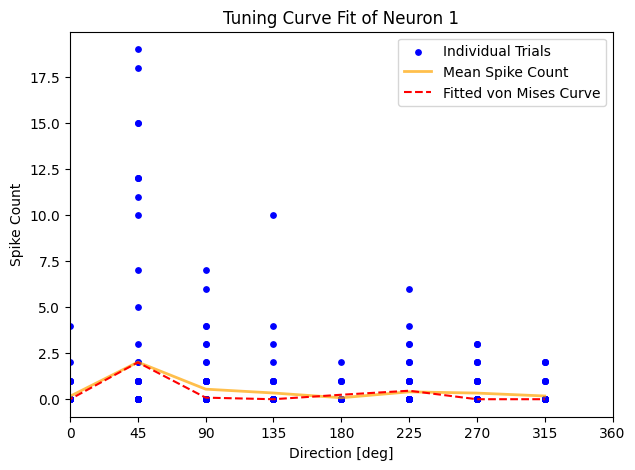

array([ -909.19559905, -1547.45248287,  2185.7502427 ,   134.98076694])

In [103]:
spike_count = get_data(stim_table, deconv_oasis, neuron=102)
tuningCurve(spike_count, np.nan_to_num(stim_table["orientation"], nan=-99))

In [81]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
    neuron: int = 1,
) -> tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    neuron: int, default=1
        id of the plotted neuron (we added this for a nicer plot)

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # Convert directions to radians
    theta_k = np.deg2rad(np.unique(dirs))
    unique_dirs = np.unique(dirs)
    m_k = np.array([np.mean(counts[dirs == d]) for d in unique_dirs])
    v_k = np.exp(psi * 1j * theta_k)
    q = np.abs(np.dot(m_k, v_k))

    rng = np.random.default_rng(random_seed)
    qdistr = np.zeros(niters)

    for i in range(niters):
        shuffled_counts = rng.permutation(counts)
        shuffled_m_k = np.array(
            [np.mean(shuffled_counts[dirs == d]) for d in unique_dirs]
        )
        qdistr[i] = np.abs(np.dot(shuffled_m_k, v_k))

    p = np.sum(qdistr >= q) / niters

    if show:
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.hist(qdistr, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
        ax.axvline(q, color="red", linestyle="--", label=f"Observed |q| = {q:.2f}")
        ax.set_xlabel("|q| Values")
        ax.set_ylabel("Frequency")
        ax.set_title(
            "Permutation Test for Direction Tuning of Neuron {}".format(neuron)
        )
        ax.set_xlim(left=0)
        ax.legend()
        plt.show()

    return p, q, qdistr

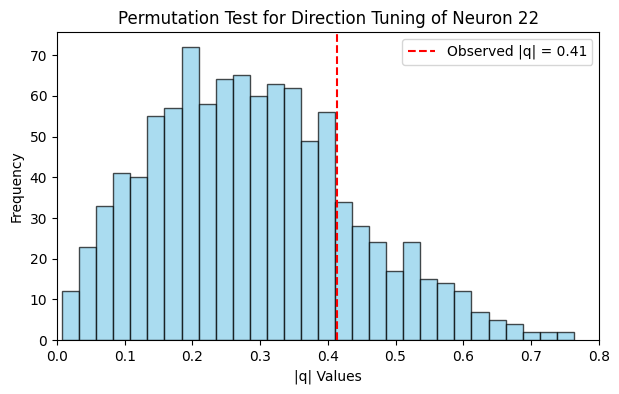

In [99]:
spike_count = get_data(stim_table, deconv_oasis, neuron=0)
p, q, qdistr = testTuning(
    spike_count, np.nan_to_num(stim_table["orientation"], nan=-99), show=True, neuron=22
)

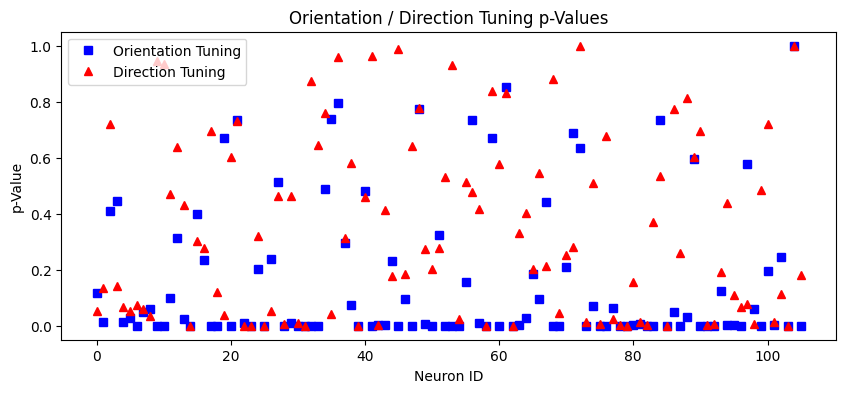

In [95]:
neurons = deconv_oasis["infspikes"].shape[0]
p_orientation = np.zeros(neurons)
p_direction = np.zeros(neurons)
for neuron in range(neurons):
    counts = get_data(stim_table, deconv_oasis, neuron=neuron)
    p, q, qdistr = testTuning(
        counts, np.nan_to_num(stim_table["orientation"], nan=-99), psi=2, show=False
    )
    p_orientation[neuron - 1] = p

# direction sensitivity is psi = 1
for neuron in range(neurons):
    counts = get_data(stim_table, deconv_oasis, neuron=neuron)
    p, q, qdistr = testTuning(
        counts, np.nan_to_num(stim_table["orientation"], nan=-99), psi=1, show=False
    )
    p_direction[neuron - 1] = p

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    p_orientation, marker="s", linestyle="None", label="Orientation Tuning", color="b"
)  # Square marker, blue color
ax.plot(
    p_direction, marker="^", linestyle="None", label="Direction Tuning", color="r"
)  # Triangle marker, red color
ax.set_xlabel("Neuron ID")
ax.set_ylabel("p-Value")
ax.set_title("Orientation / Direction Tuning p-Values")
ax.legend(frameon=True)
plt.show()

In [97]:
n_direction_tuned = np.sum(p_direction <= 0.01)
print(f"Number of direction tuned neurons: {n_direction_tuned}")
print(f"Neurons: {np.where(p_direction <= 0.01)[0].tolist()}")

Number of direction tuned neurons: 20
Neurons: [14, 22, 23, 25, 28, 30, 31, 39, 42, 58, 62, 75, 78, 79, 82, 85, 91, 92, 98, 103]


In [98]:
n_orientation_tuned = np.sum(p_orientation <= 0.01)
print(f"Number of orientation tuned neurons: {n_orientation_tuned}")
print(f"Neurons: {np.where(p_orientation <= 0.01)[0].tolist()}")

Number of orientation tuned neurons: 55
Neurons: [6, 9, 10, 14, 17, 18, 20, 22, 23, 25, 28, 29, 30, 31, 32, 33, 39, 41, 42, 43, 45, 47, 49, 50, 52, 53, 54, 57, 58, 60, 62, 63, 68, 69, 73, 75, 76, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 94, 95, 96, 99, 101, 103, 105]


Todo:

- plot oben zum laufen kriegen
- peri stimulius time plots aus CL4
- Unterschied direction / orientation? Wir haben orientation gegeben, in CL4 war direction of motion gegeben? 
--> muss man die tuning function anpassen? Wenn ja wie? 

- spatial structure: preferred orientation (max der tuning curve) einfärben (wenn signifikant?)

- überlegen wie spatial frequency da rein kommt und warum temporal frequency gegeben wurde 

- Complex / simple cells 